# Energy Consumption Reduction Prediction Challenge: A Real-World Trial Analysis

In [1]:
# Import libraries
import glob
# import pickle
import warnings
# import itertools
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import scipy.stats as stats
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
# SOME CONSTANTS
PROCESSED_DATA_PATH = "../data/processed"
RAW_DATA_PATH = "../data/raw"

# Import Data

Data wrangling function
- [x] load data, check shape and global info
- [x] variables type:
  - [x] integer or float
  - [x] string normalization (strip, case), 
  - [x] boolean normalization (true, false -> True, False)
  - [x] date normalization
  - [x] Normalize missing values indicator ()
- [x] missing values
  - [x] Missing rates (delete "high" missing values rate columns)
  - [-] Potential causes (MCAR, MAR, NMAR / Random, Direct, Indirect, Hybrid), (https://cremilleux.users.greyc.fr/papers/dawak09final.pdf)
- [ ] outliers ? (what does it mean)
- [-] low- and high-cardinality variables (recoding suggestion?)
- [-] leakage variables (w.r.t. the modelization objective)

In [3]:
def load_data(data_rootpath: str) -> pd.DataFrame:
    """
    Load data from CSV files in the specified directory and merge them.

    Args:
        data_rootpath (str): The root path of the data files.

    Returns:
        pd.DataFrame: Merged DataFrame.
    """
    # Get all filenames in the folder and load each of them.
    files = glob.glob(rf"{data_rootpath}/*")
    dfs = [pd.read_csv(file, sep=";", decimal=".") for file in files]
    # Merge DataFrames based on the 'ID' column.
    merged_data = pd.merge(dfs[0], dfs[1], how="inner", on="ID")
    
    return merged_data


def normalize_columns(data: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize all columns in a DataFrame.

    Args:
        data (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: Normalized DataFrame.
    """
    data = data.copy()
    data = (
        data.fillna(np.nan) # consistent missing values
        .replace({True: "True", False: "False"})
    )
    
    # Normalize string columns.
    catcols = data.select_dtypes(object).columns
    data[catcols] = data[catcols].apply(lambda x: x.str.upper().str.strip().replace({"TRUE": "True", "FALSE": "False"}))

    # Normalize date columns
    s_cols = data.filter(regex='^S[3-7]').columns
    # # Enforce numeric type when possible.
    data[s_cols] = data[s_cols].apply(lambda x: pd.to_datetime(x, errors="ignore", format="%Y-%m-%d"))
    
    
    data = data.convert_dtypes(convert_string=False).replace(pd.NA, np.nan) 
    return data


def wrangle(filepath: str) -> pd.DataFrame:
    """
    Load, normalize, and wrangle data from CSV files.

    Args:
        filepath (str): The path to the CSV files.

    Returns:
        pd.DataFrame: Wrangled DataFrame.
    """
    # Load data from CSV files and merge them.
    data = load_data(filepath)
    # Normalize columns data types.
    data = normalize_columns(data)

    return data

In [4]:
# Load data.
elec_df = wrangle(RAW_DATA_PATH)

In [5]:
# Shape, global information (columns types), and head.
print(f"(No. Observations, No. Columns): {elec_df.shape}\n")

print(elec_df.info())

elec_df.head(3)

(No. Observations, No. Columns): (85529, 110)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85529 entries, 0 to 85528
Columns: 110 entries, ID to TARGET
dtypes: Float64(5), Int64(54), datetime64[ns](5), object(46)
memory usage: 76.6+ MB
None


,ID,COD_INSEE,COD_IRIS,C1,C2,C3,C4,C5,C6,C7,...,Q67,Q68,Q69,Q70,Q71,Q72,Q73,Q74,Q75,TARGET
0,0,92025,920250102,EA,RA,C,IB,0,0,0,...,False,True,False,True,False,False,NaN,NaN,NaN,0
1,1,17359,173590000,EA,RA,C,IA,0,0,0,...,False,True,False,True,False,False,True,False,False,0
2,2,48156,481560000,EA,RC,B,IA,0,0,0,...,False,True,False,True,False,False,NaN,NaN,NaN,0


In [6]:
# Columns groups
contract_res_cols = elec_df.filter(regex='^C\d').columns
aids_use_cols = elec_df.filter(regex='^S\d').columns
elec_usage_cols = elec_df.filter(regex='^Q\d').columns

# Check info by group
labels = ["Contract and residence", 
          "Use of proposed aids", 
          "Equipment owning, electricity usage & occupancy periods"]
col_groups = [contract_res_cols, aids_use_cols, elec_usage_cols]
for label, cols in zip(labels, col_groups):
    print(f"\n{label}: {cols.shape[0]} variables. {cols[:5]}\n")
    print({elec_df[cols].info(verbose=False)})


Contract and residence: 19 variables. Index(['C1', 'C2', 'C3', 'C4', 'C5'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85529 entries, 0 to 85528
Columns: 19 entries, C1 to C19
dtypes: Int64(10), object(9)
memory usage: 13.2+ MB
{None}

Use of proposed aids: 12 variables. Index(['S1', 'S2', 'S3', 'S4', 'S5'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85529 entries, 0 to 85528
Columns: 12 entries, S1 to S12
dtypes: Int64(7), datetime64[ns](5)
memory usage: 8.4 MB
{None}

Equipment owning, electricity usage & occupancy periods: 75 variables. Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85529 entries, 0 to 85528
Columns: 75 entries, Q1 to Q75
dtypes: Float64(5), Int64(33), object(37)
memory usage: 52.0+ MB
{None}


#### Missing values

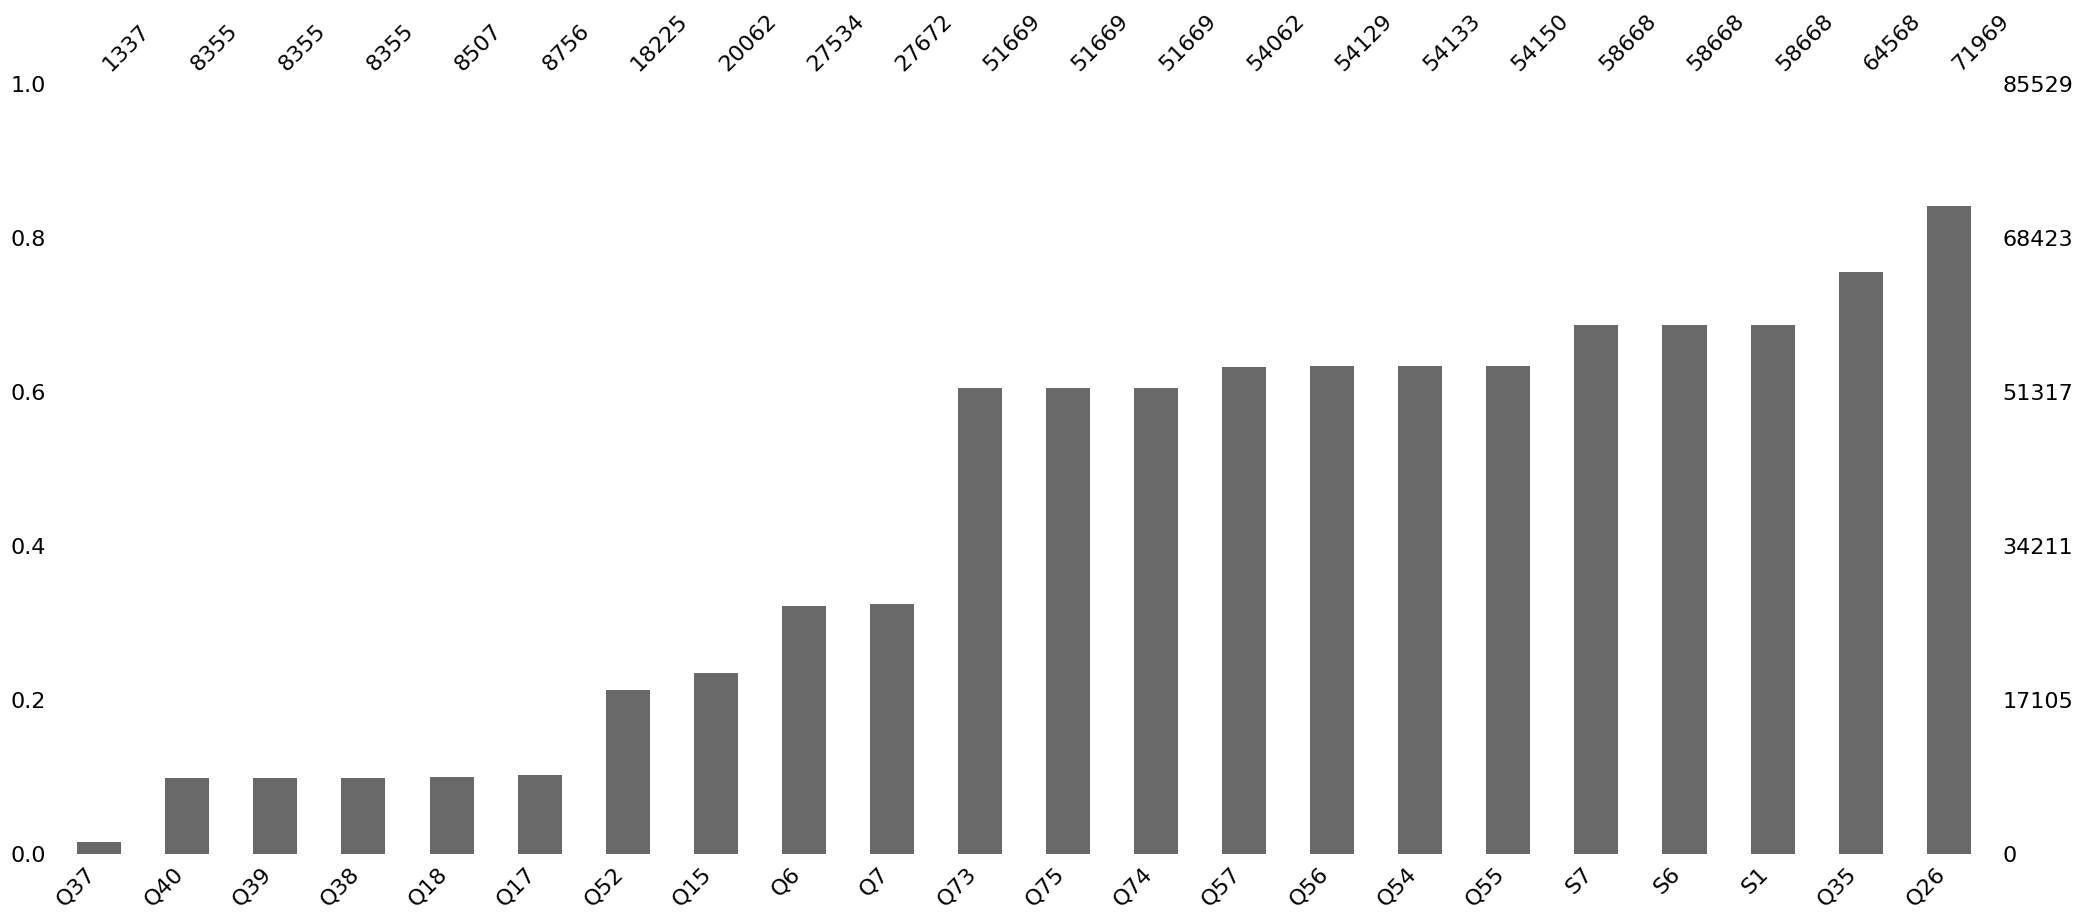

In [7]:
# Count no-missing.
msno.bar(elec_df, filter="bottom", p=0.9, sort="ascending");

In [8]:
# Nullity correlation matrix.
# msno.heatmap(elec_df, filter="bottom", p=0.9, sort="ascending");

In [9]:
todrop_columns_missing = elec_df.isna().sum()[elec_df.isna().sum() / len(elec_df) > 0.4].index

* Variables marked with the prefix Q exhibit a higher susceptibility to missing values, as indicated by their ranking in descending order of missing rates on the x-axis of the heatmap presented above. Additionally, certain variables demonstrate a notable correlation in terms of nullity. For instance, the absence of values in Q38 consistently coincides with missing values in Q39 and Q40, suggesting a sequential relationship (Q38 -> Q39 -> Q40) with a decreasing rate of missing values. Similar patterns are observed in pairs such as Q17-Q18, Q73-Q75, and Q57-Q55. It's crucial to note that these variables are associated with the presence of electrical equipment in households, usage patterns, and occupancy periods. On the other side, the nullity of Q6-Q7 is inversely linked to that of Q55-Q57.
 
* Positive correlations can be attributed to common usage patterns, dependencies on equipment presence (complementary accessories), or links between occupancy and usage. Conversely, negative correlations, may indicate the presence of substitute equipment or variations in lifestyle.

> POSSIBLE SOLUTIONS
> 
> We might probably more likely consider only a subset of each group of variables based on their inter-correlation and their link with the target variable.
> * Delete columns with high missing rate (possibly after having created new feature using combination of transformation of existing ones).
> * Impute missing values during the training step of the modelling.
> * Use algorithms that are robust to or handle automatically missing value.

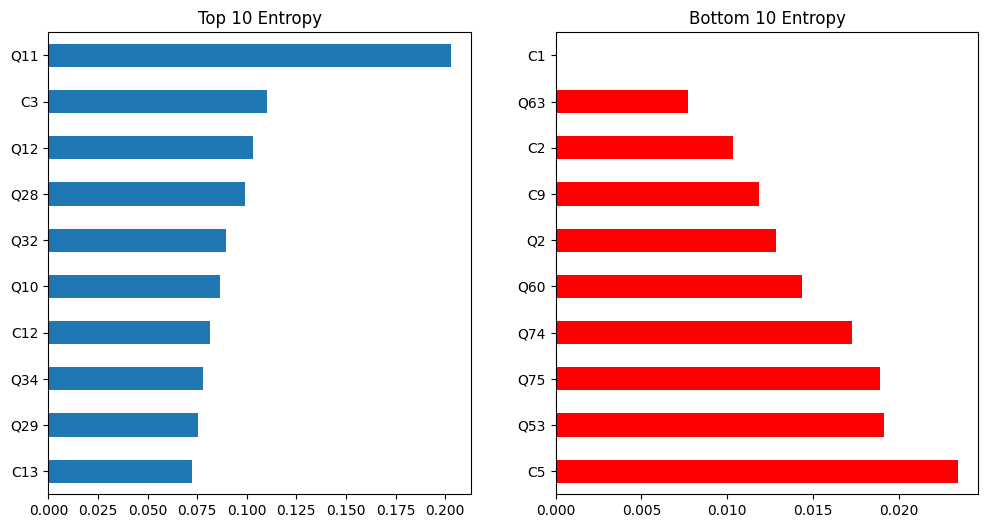

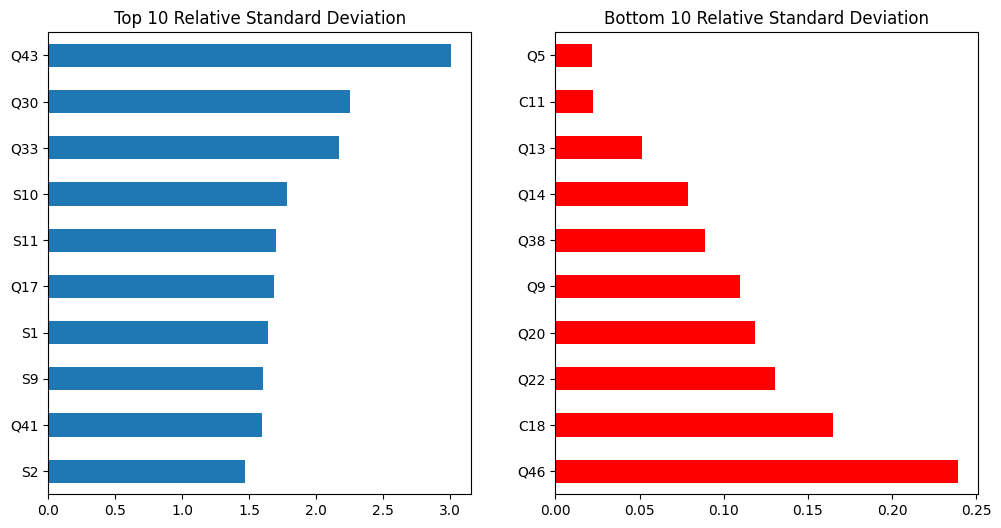

In [10]:
#TODO: Use it later (just before 1st features choices)
# Compute entropy for discrete variables and variance for continous variables.
# --> assess the quantity of information provided by each variable.
def entropy_array(column_series: pd.Series, normalize: bool=False) -> float:
    """Compute the entropy.

    Args:
        column_series (pd.Series): a series
        normalize (bool, optional): whether to normalize the entropy by 
            the number of class in the series. Defaults to False.

    Returns:
        float: entropy of the series
    """
    n_classes = len(column_series)
    if n_classes <= 1:
        return 0 
    
    # Compute frequencies then entropy.
    value_counts = column_series.value_counts(normalize=True)
    entropy = -np.sum(value_counts * np.log2(value_counts)) 
    
    if normalize:
        return entropy / np.log2(n_classes)
    return entropy

def compute_entropies(df: pd.DataFrame, normalize=False, include=["object", "string"]):
    categorical_columns = df.select_dtypes(include=include).columns
    other_binary_columns = df.select_dtypes("number").columns[df.select_dtypes("number").nunique() == 2]
    categorical_columns = categorical_columns.append(other_binary_columns) 
    entropies = {column: entropy_array(df[column], normalize=normalize) for column in categorical_columns}
    return entropies

# -----------------------------------
# ---- CATEGORICAL VARIABLES --------
# -----------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Compute entropies for all categorical variables.
entropy_series = pd.DataFrame.from_dict(compute_entropies(elec_df), orient="index")[0]
# entropy_series.sort_values().tail(20).plot(kind="barh", ax=axes[0])
# entropy_series.sort_values().head(20).plot(kind="barh", ax=axes[1])

relative_entropy_series = pd.DataFrame.from_dict(compute_entropies(elec_df, True), orient="index")[0]
relative_entropy_series.sort_values().tail(10).plot(kind="barh", title="Top 10 Entropy", ax=axes[0])
relative_entropy_series.sort_values(ascending=False).tail(10).plot(kind="barh", title="Bottom 10 Entropy", ax=axes[1], color="red")
plt.show()


# ---------------------------------
# ---- NUMERICAL VARIABLES --------
# ---------------------------------
# Relative coefficient.
other_binary_columns = elec_df.select_dtypes("number").columns[elec_df.select_dtypes("number").nunique() == 2]
number_columns = elec_df.select_dtypes("number").columns.difference(other_binary_columns)
variation_coefficient = elec_df[number_columns].std().sort_index() / elec_df[number_columns].mean().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
variation_coefficient.sort_values().tail(10).plot(kind="barh", title="Top 10 Relative Standard Deviation", ax=axes[0])
variation_coefficient.sort_values(ascending=False).tail(10).plot(kind="barh", title="Bottom 10 Relative Standard Deviation", ax=axes[1], color="red")
plt.show()

In [11]:
tokeep_cols_rstd = variation_coefficient.sort_values().tail(10)
tokeep_cols_entropy = relative_entropy_series.sort_values().tail(10)

> * For the moment, we do not systematically remove variables with lower information (lower entropy for categorical or lower variance for numerical) because some of them might still be stronlgy correlated with the target variable (while being unrelated with the lower), giving them highly predictive power. Neverthless, considering this approach will assist us in choosing features from groups of correlated ones. (This analysis should be run again after removing outliers).

#### Low- and high-cardinality variables and Leakage variables

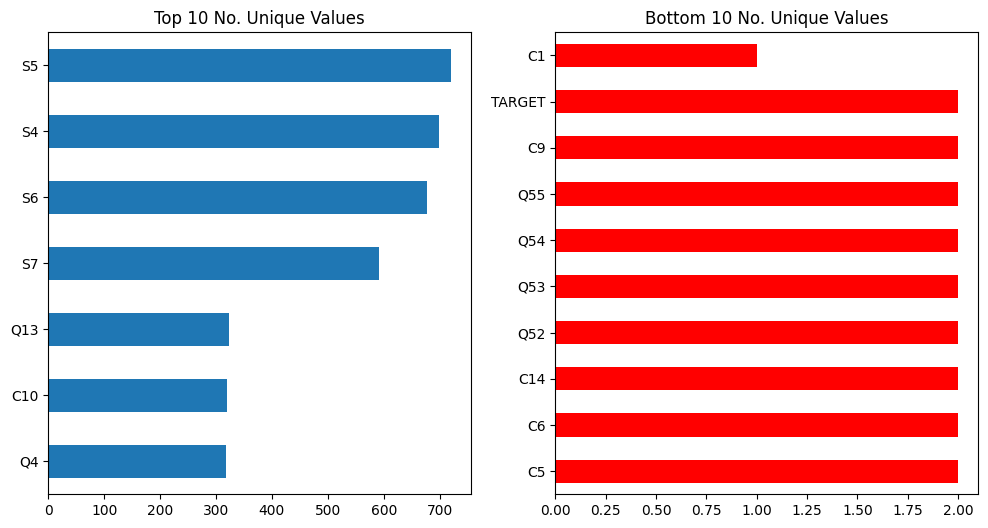

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Column cardinality (no. unique values per column).
cardinality_series = elec_df.nunique()
(
    cardinality_series.sort_values().tail(10)[:-3]
    .plot(kind="barh", title="Top 10 No. Unique Values", ax=axes[0])
)
(
    cardinality_series.sort_values(ascending=False).tail(10)
    .plot(kind="barh", title="Bottom 10 No. Unique Values", ax=axes[1], color="red")
 )
plt.show()

* "**ID**," as an identifier, is obviously a leakage variable. Here, we won't delve further, but one might consider a combination of variables that uniquely identify each line (coincidental relationship) that would need to be removed, if applicable. More generally, any categorical variables with "high" cardinality (compared to the sample size) would have lower variance. We would like to reduce the number of distinct categories, improve interpretability, or create more meaningful and manageable representations of the data.

* On the opposite side, "**C1**" has only one class (does not vary), rendering it useless for prediction (provides no information).

> **POSSIBLE SOLUTIONS**
> * Recode high-cardinality variables into a fewer number of classes (aggregation at higher-level).
>   * Particularly for `COD_INSEE`, we can explore a higher regional level (does it make sense? Perhaps, if electricity consumption behaviors are similar at the chosen level). Or group zone by zone (urban vs rural), size (big city vs small town) and geographical location (north, south, east, west).
> * Consider using `TargetEncoder`. `TargetEncoder` involves replacing each category of a variable with the average of the target variable in that category (e.g., replacing a region with the average consumption (here the proportion of people that have reduced their consumption)).
> * 
>
> **LIMITATIONS (contextual)**
> * Limited knowledge on variable: higher-level aggregation is less trivial for categorial variable -> use representativeness (keep most frequent classes and group all the others)


In [13]:
# Columns to drop.
todrop_columns = pd.Index(["ID", "C1"])
# Column to consider for recoding (those with more than 10 classes).
torecode_columns = cardinality_series[(cardinality_series > 10)].index.drop(todrop_columns, errors="ignore")
print(torecode_columns)

Index(['COD_INSEE', 'COD_IRIS', 'C10', 'C11', 'C15', 'C16', 'C17', 'C18',
       'C19', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
       'S11', 'S12', 'Q4', 'Q5', 'Q9', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15',
       'Q18', 'Q19', 'Q20', 'Q22', 'Q30', 'Q31', 'Q33', 'Q35', 'Q37', 'Q38',
       'Q40', 'Q48', 'Q51'],
      dtype='object')


In [14]:
# Save processed data.
elec_df.to_parquet(rf"{PROCESSED_DATA_PATH}/training_df_with_dtypes.parquet")

# Exploratory Data Analysis - Descriptive Statistics

- [ ] Potential bias issues (resource allocation or quality of service, qualitative assessement of sensitive features)
- [ ] univariate distribution (categorial, numerical)
- [ ] bivariate distribution (correlations, numerical vs numerical, categorial vs categorial, numerical vs categorial

#### Univariate distribution

In [15]:
# Numerical
describe_df = elec_df.describe().T
describe_df.insert(0, column="rstd", value=describe_df["std"] / describe_df["mean"])
describe_df.sort_values("rstd", ascending=False, na_position="last")

,rstd,count,mean,min,25%,50%,75%,max,std
C5,3.512401,85529.0,0.07498,0.0,0.0,0.0,0.0,1.0,0.263361
C7,3.317766,85529.0,0.083282,0.0,0.0,0.0,0.0,1.0,0.276309
Q43,3.007485,84678.0,0.101975,0.0,0.0,0.0,0.0,3.0,0.306687
Q30,2.252667,84762.0,0.998985,0.0,0.0,0.0,1.0,26.0,2.250381
Q33,2.170221,84760.0,0.845328,0.0,0.0,0.0,1.0,21.0,1.834549
...,...,...,...,...,...,...,...,...,...
S3,NaN,85529,2013-12-17 08:45:23.791930624,2013-11-15 00:00:00,2013-11-15 00:00:00,2013-11-15 00:00:00,2014-01-17 00:00:00,2014-08-17 00:00:00,NaN
S4,NaN,85529,2014-05-02 04:06:22.017795328,2011-12-13 00:00:00,2014-03-18 00:00:00,2014-06-04 00:00:00,2014-07-25 00:00:00,2014-08-15 00:00:00,NaN
S5,NaN,85529,2013-11-05 08:47:24.003788288,2011-12-13 00:00:00,2013-09-06 00:00:00,2013-11-09 00:00:00,2014-02-12 00:00:00,2014-06-23 00:00:00,NaN
S6,NaN,58668,2013-12-27 17:13:20.409081600,2011-11-13 00:00:00,2013-10-16 00:00:00,2014-01-15 00:00:00,2014-03-23 00:00:00,2014-07-26 00:00:00,NaN


In [16]:
# Split data by variable group (for further analysis by group of variables)
target = "TARGET"
sample_df = elec_df.sample(frac=0.25, replace=False, random_state=42)
num_cols = elec_df.select_dtypes("number").drop(columns=["COD_INSEE", "COD_IRIS"]).columns
select_num_cols = sample_df[num_cols].isna().sum()[(sample_df[num_cols].isna().sum() < 0.05 * len(sample_df))].index.drop("ID")
s_numcols_C = select_num_cols[select_num_cols.str.startswith("C")].insert(-1, target)
s_numcols_S = select_num_cols[select_num_cols.str.startswith("S")].insert(-1, target)
s_numcols_Q = select_num_cols[select_num_cols.str.startswith("Q")].insert(-1, target)
df = sample_df[select_num_cols].fillna(sample_df[select_num_cols].mean().astype(int))

df = df.astype(float)
# sns.pairplot(df[s_numcols_C], hue=target)

In [17]:
def plot_kde_grid(data, columns, grid_cols=3, hue=None):
    """
    Plot KDE plots for specified columns in a grid.

    Parameters:
    - data: DataFrame
    - columns: List of column names to plot
    - grid_cols: Number of columns in the grid
    - hue: Column name to use for color encoding

    Returns:
    - None (displays the grid of KDE plots)
    """
    # Calculate the number of rows needed in the grid
    print("len columns", len(columns))
    grid_rows, reminder = divmod(len(columns) - (1-(not hue)), grid_cols)
    print("reminder", reminder)
    grid_rows += (reminder > 0)  # assess if there remain some columns
    # grid_rows = int(np.floor(len(columns) / grid_cols)) + 
    print(grid_rows)

    # Create a grid of subplots
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(5 * grid_cols, 4 * grid_rows))
    axes = axes.flatten()

    # Loop through each column and plot KDE
    for i, column in enumerate(columns.drop(target)):
        ax = axes[i]
        if not hue:
            sns.kdeplot(data[column], ax=ax, fill=True)
        else:
            for hue_level in data[hue].unique():
                subset_data = data[data[hue] == hue_level]
                sns.kdeplot(subset_data[column], ax=ax, fill=True, label=f"{hue_level}", common_norm=False)

        ax.set_title(column)
        ax.set_xlabel('')
        ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming df is your DataFrame and columns_to_plot is a list of column names
# plot_kde_grid(df, select_num_cols, grid_cols=4, hue="TARGET")


#### Goodness-of-fit Tests

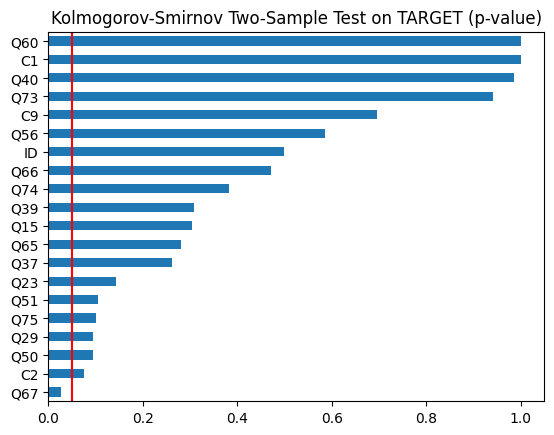

In [18]:
def test_distribution_difference_all(data: pd.DataFrame, target_variable: str, feature_variables: List[str] | pd.Index):
    """
    Test the difference of distribution between two classes of a target variable for a list of feature variables.

    Parameters:
    - data: DataFrame
    - target_variable: Column name of the target variable (binary)
    - feature_variables: List of column names of feature variables

    Returns:
    - result_dict: Dictionary containing test statistics and p-values for each feature variable
    """
    result_dict = {
        feature: test_distribution_difference(data, target_variable, feature) if data[feature].dtype == ("O", "S") else
        test_distribution_difference_categorical(data, target_variable, feature) for feature in feature_variables.drop(target_variable)
    }

    # for feature in feature_variables:
    #     if data[feature].dtype == 'O':
    #         # Categorical variable
    #         chi2_stat, p_value = test_distribution_difference_categorical(data, target_variable, feature)
    #     else:
    #         # Continuous variable
    #         test_stat, p_value = test_distribution_difference(data, target_variable, feature)

    #     result_dict[feature] = [test_stat, p_value]

    return result_dict

def test_distribution_difference(data, target_variable, feature_variable, equal_var=False):
    """
    Test the difference of distribution between two classes of a target variable for a continuous feature variable.

    Parameters:
    - data: DataFrame
    - target_variable: Column name of the target variable (binary)
    - feature_variable: Column name of the continuous feature variable

    Returns:
    - test_statistic: Test statistic
    - p_value: p-value
    """
    class_0 = data[data[target_variable] == 0][feature_variable]
    class_1 = data[data[target_variable] == 1][feature_variable]

    # # Assuming the data is approximately normally distributed
    # test_statistic, p_value = stats.ttest_ind(class_0, class_1, equal_var=equal_var)

    # # Cramér-von Mises test
    # test_statistic, p_value = stats.cramervonmises(class_0, class_1)

    # Kolmogorov-Smirnov test
    test_statistic, p_value = stats.ks_2samp(class_0, class_1)

    return test_statistic, p_value

def test_distribution_difference_categorical(data, target_variable, categorical_variable):
    """
    Test the difference of distribution between two classes of a target variable for a categorical variable.

    Parameters:
    - data: DataFrame
    - target_variable: Column name of the target variable (binary)
    - categorical_variable: Column name of the categorical variable

    Returns:
    - chi2_statistic: Chi-squared statistic
    - p_value: p-value
    """
    contingency_table = pd.crosstab(data[target_variable], data[categorical_variable])
    chi2_statistic, p_value, _, _ = stats.chi2_contingency(contingency_table)

    return chi2_statistic, p_value


result_dict = test_distribution_difference_all(elec_df, target, elec_df.columns)
test_result_df = (
    pd.DataFrame.from_dict(result_dict, orient="index", columns=["statistics", "p_value"])["p_value"]
    .sort_values()
)
test_result_df.tail(20).plot(kind="barh", title="Kolmogorov-Smirnov Two-Sample Test on TARGET (p-value)")
plt.axvline(0.05, color="red")
plt.show()


In [19]:
todrop_columns_corrtest = test_result_df[test_result_df > 0.05].index
tokeep_columns_corrtest = test_result_df[test_result_df < 0.001].index
todrop_columns_corrtest 

Index(['C2', 'Q50', 'Q29', 'Q75', 'Q51', 'Q23', 'Q37', 'Q65', 'Q15', 'Q39',
       'Q74', 'Q66', 'ID', 'Q56', 'C9', 'Q73', 'Q40', 'C1', 'Q60'],
      dtype='object')

len columns 13
reminder 0
3


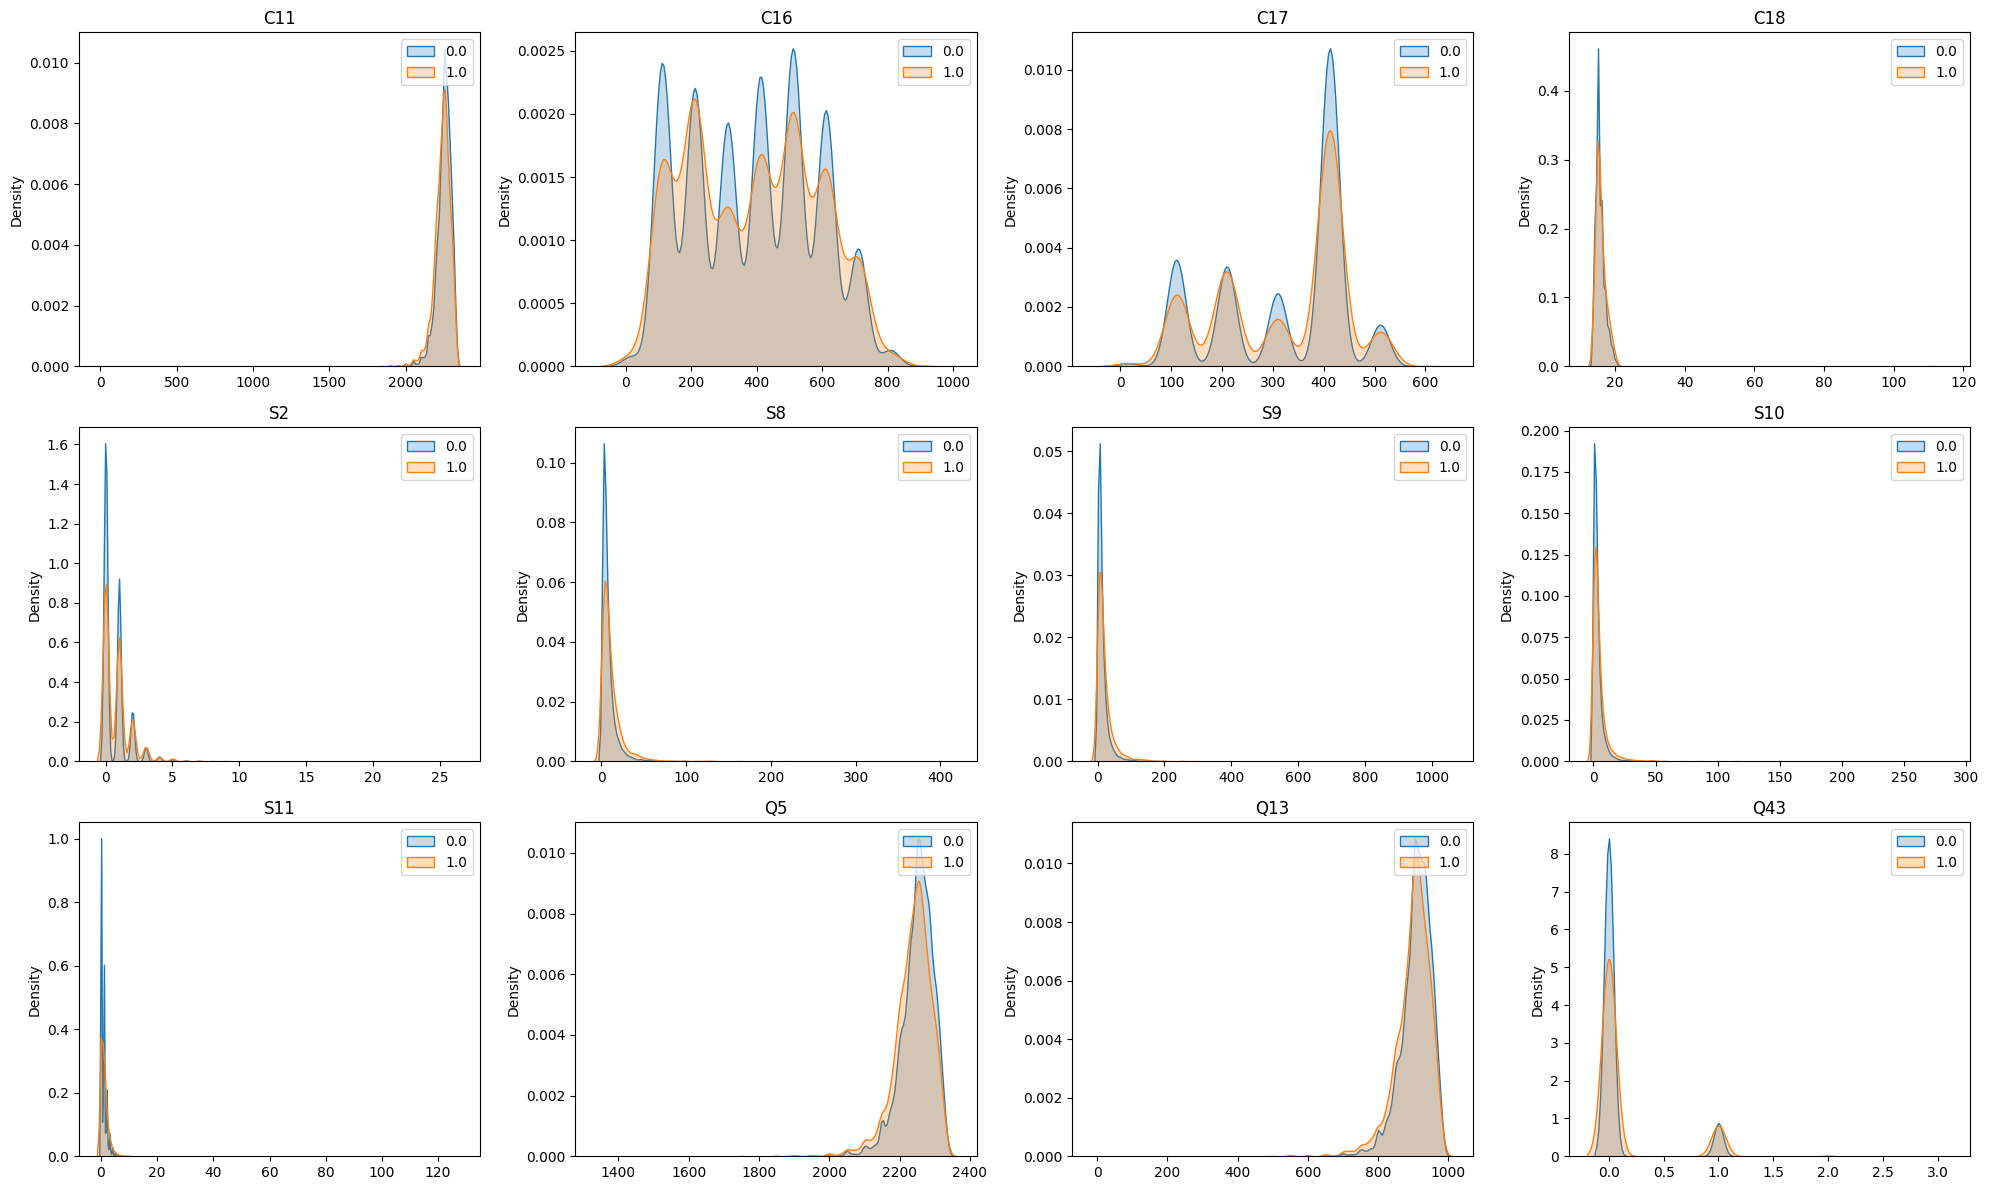

In [20]:
# Focus on the "prentended" more significant variable
num_cols_plot = select_num_cols.intersection(test_result_df.head(30).index.append(pd.Index([target])))
plot_kde_grid(df, num_cols_plot, grid_cols=4, hue="TARGET")

* Individual who change reduce their consumption seem to have flatter distribution for observable features. Individuals with "extreme" (high and low) values for caracteristics are more proned to reduce their consumption.

In [21]:
# Categorical
elec_df.describe(include="O").T[:5]

,count,unique,top,freq
C1,85529,1,EA,85529
C2,85529,4,RA,83692
C3,85529,9,B,34515
C4,85529,2,IB,64050
C8,85529,2,YB,57655


In [22]:
# catcols_df = elec_df.select_dtypes(object).merge(elec_df[target], left_index=True, right_index=True)
# # Assuming catcols_df is a list of categorical column names and target is the target column name
# fig, axes = plt.subplots(ncols=1, nrows=len(catcols_df), figsize=(20, 5))

# catcols_df.apply()

# plt.show()

#### Bivariate analysis

In [23]:
print(elec_df.select_dtypes("number").shape)
len(select_num_cols)

(85529, 59)


45

In [24]:
threshold = 0.9

def corr_matrix_threshold(df: pd.DataFrame,
                          cols: List[str],
                          method: str = "pearson",
                          threshold: float = 0.7,
                          cmap: str="coolwarm"):
    # Correlation matrix
    corr_matrix_pearson = df[cols].corr(method=method)
    np.fill_diagonal(corr_matrix_pearson.values, np.nan)
    # Select columns where at least one coefficient is above the threshold
    selected_cols = (corr_matrix_pearson.abs() > threshold).any()
    # Display the matrix formed only by these columns
    high_corr_matrix = corr_matrix_pearson.loc[selected_cols, selected_cols]
    # Display the matrix
    return high_corr_matrix.style.background_gradient(cmap=cmap)
    

corr_matrix_threshold(elec_df, select_num_cols, threshold=0.7)

,C10,C11,C15,C16,C17,S8,S9,S10,Q4,Q5,Q13,Q19,Q21,Q23
C10,nan,-0.053496,-0.040674,0.042189,0.032890,-0.017764,-0.020180,-0.027360,0.970306,-0.053893,-0.058099,-0.040891,0.024812,0.023565
C11,-0.053496,nan,-0.403505,-0.269481,-0.259115,-0.009060,-0.038995,-0.031058,-0.057275,0.983936,0.914533,-0.404790,0.043544,0.048669
C15,-0.040674,-0.403505,nan,0.127890,0.148949,-0.007799,0.018677,0.025956,-0.041993,-0.407729,-0.367704,0.993733,-0.069778,-0.075630
C16,0.042189,-0.269481,0.127890,nan,0.866974,-0.001914,0.060010,-0.005005,0.042175,-0.271881,-0.246303,0.127619,0.012088,0.008075
C17,0.032890,-0.259115,0.148949,0.866974,nan,-0.015134,0.051340,-0.018164,0.033995,-0.261820,-0.234746,0.148747,-0.009009,-0.007674
S8,-0.017764,-0.009060,-0.007799,-0.001914,-0.015134,nan,0.914712,0.678396,-0.017937,-0.008993,-0.000813,-0.007956,-0.007888,-0.010836
S9,-0.020180,-0.038995,0.018677,0.060010,0.051340,0.914712,nan,0.793480,-0.020294,-0.039442,-0.025909,0.018397,-0.011035,-0.013643
S10,-0.027360,-0.031058,0.025956,-0.005005,-0.018164,0.678396,0.793480,nan,-0.026946,-0.031380,-0.017779,0.025824,-0.013253,-0.015287
Q4,0.970306,-0.057275,-0.041993,0.042175,0.033995,-0.017937,-0.020294,-0.026946,nan,-0.056957,-0.061999,-0.042131,0.024986,0.023025
Q5,-0.053893,0.983936,-0.407729,-0.271881,-0.261820,-0.008993,-0.039442,-0.031380,-0.056957,nan,0.929121,-0.409607,0.043068,0.047921


In [25]:
corr_matrix_threshold(elec_df, select_num_cols, method="kendall", threshold=0.7)

,C10,C11,C15,C16,C17,S8,S9,Q4,Q5,Q13,Q19,Q21,Q23
C10,nan,0.025822,-0.067315,0.076180,0.057205,-0.023804,-0.027319,0.994339,0.025423,0.010198,-0.067532,0.023940,0.022220
C11,0.025822,nan,-0.367545,-0.213560,-0.201162,-0.024423,-0.052053,0.025510,0.991594,0.820661,-0.368285,0.036840,0.042397
C15,-0.067315,-0.367545,nan,0.099881,0.108923,-0.010026,0.026380,-0.067447,-0.367541,-0.331304,0.991880,-0.066163,-0.071837
C16,0.076180,-0.213560,0.099881,nan,0.729082,-0.013426,0.039239,0.076256,-0.213732,-0.192906,0.099668,0.006276,0.002667
C17,0.057205,-0.201162,0.108923,0.729082,nan,-0.031689,0.018035,0.057571,-0.200953,-0.179651,0.108611,-0.007636,-0.006672
S8,-0.023804,-0.024423,-0.010026,-0.013426,-0.031689,nan,0.771643,-0.023550,-0.024252,-0.014030,-0.010109,-0.009794,-0.011356
S9,-0.027319,-0.052053,0.026380,0.039239,0.018035,0.771643,nan,-0.027088,-0.051905,-0.036648,0.026498,-0.015213,-0.017570
Q4,0.994339,0.025510,-0.067447,0.076256,0.057571,-0.023550,-0.027088,nan,0.025140,0.010026,-0.067640,0.023742,0.021809
Q5,0.025423,0.991594,-0.367541,-0.213732,-0.200953,-0.024252,-0.051905,0.025140,nan,0.826367,-0.368724,0.037026,0.042328
Q13,0.010198,0.820661,-0.331304,-0.192906,-0.179651,-0.014030,-0.036648,0.010026,0.826367,nan,-0.332448,0.037750,0.044656


* +(C10, Q4), || +(Q5, Q13, C11) vs +(Q19, C15)
* +(Q23, Q21) || +(S8, S9, S10) || +(C16, C17)
* 

* Agglomerative Clustering is a family of algorithms that build cluster by merging or splitting them iteratively. It's the only one base on _pairwise_ distance making it suitable for feature clustering based on pairwise correlation.

In [26]:
from sklearn.cluster import AgglomerativeClustering

# Correlation matrix
corr_matrix_pearson = elec_df[select_num_cols].corr()
# Set diagonal coefficients to zero
np.fill_diagonal(corr_matrix_pearson.values, 0)

# Perform hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.8)
cluster_labels = clustering.fit_predict(corr_matrix_pearson)

# Add cluster labels to the original DataFrame
corr_matrix_pearson['Cluster'] = cluster_labels + 1  # Adding 1 to start the cluster labels from 1

# Visualize the clustered heatmap
# sns.clustermap(corr_matrix_pearson, row_cluster=True, col_cluster=True, cmap='coolwarm', figsize=(10, 8))
# plt.show()

In [27]:
# Populate the dictionary with feature names using a list comprehension
features_per_cluster = {cluster: [] for cluster in corr_matrix_pearson['Cluster'].sort_values().unique()}
[features_per_cluster[cluster].append(feature) for feature, cluster in zip(select_num_cols, corr_matrix_pearson['Cluster'])]
features_per_cluster

{1: ['C5', 'C18', 'Q9', 'Q22', 'Q24', 'Q25', 'Q27', 'Q33', 'TARGET'],
 2: ['Q44', 'Q45', 'Q46', 'Q47', 'Q48', 'Q49', 'Q50', 'Q51'],
 3: ['S2', 'S11', 'S12'],
 4: ['Q41', 'Q43'],
 5: ['C6', 'C7', 'Q30', 'Q31'],
 6: ['Q5'],
 7: ['Q13'],
 8: ['Q23'],
 9: ['S10'],
 10: ['Q42'],
 11: ['Q8', 'Q14', 'Q20'],
 12: ['C15'],
 13: ['C17'],
 14: ['Q4'],
 15: ['C16'],
 16: ['C10'],
 17: ['Q21'],
 18: ['C11'],
 19: ['S8'],
 20: ['Q19'],
 21: ['C19'],
 22: ['S9']}

* To identify features for selection, examining feature clustering based on correlation can be useful. If certain features exhibit strong correlation (e.g., above 0.7), they essentially convey the same information. Consequently, retaining all of them is not that much relevant, and a selection process becomes necessary. This can impact the performance of most models, albeit some may exhibit greater robustness. 

**POSSIBLE SOLUTIONS:**

> * Remove features within each correlation cluster
>   * Arbitrarily
>   * Based on those with the most variability/entropy
> * Incorporate feature selection techniques into the preprocessing pipeline
> * Utilize regularization


#### Creating Recoded variables and new features

In [28]:
elec_df["S_n_visits_3_7"] = elec_df[['S3', 'S4', 'S5', 'S6', 'S7']].count(axis=1)
elec_df["Q_n_equips_53_75"] = elec_df.loc[:, "Q53":"Q75"].count(axis=1)

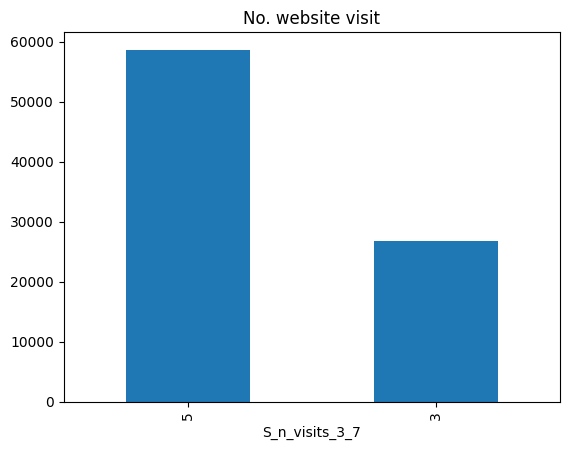

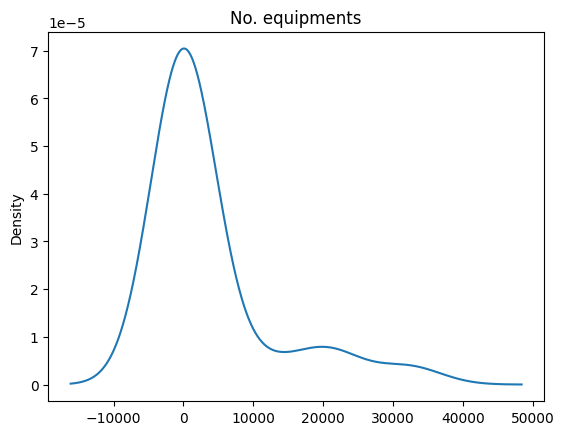

In [29]:
elec_df["S_n_visits_3_7"].value_counts().plot(kind="bar", title="No. website visit")
plt.show()
elec_df["Q_n_equips_53_75"].value_counts().plot(kind="kde", title="No. equipments")
plt.show()

In [43]:
### Delete ID columns and (no-relevant and missing)
select_df = elec_df.drop(columns=
    todrop_columns.union(todrop_columns_corrtest.union(todrop_columns_missing))
)
select_df = select_df.drop(columns=['S3', 'S4', 'S5', 'S6', 'S7'])
select_df

,COD_INSEE,COD_IRIS,C3,C4,C5,C6,C7,C8,C10,C11,...,Q64,Q67,Q68,Q69,Q70,Q71,Q72,TARGET,S_n_visits_3_7,Q_n_equips_53_75
0,92025,920250102,C,IB,0,0,0,YA,8,2286,...,False,False,True,False,True,False,False,0,5,16
1,17359,173590000,C,IA,0,0,0,YB,166,2220,...,False,False,True,False,True,False,False,0,5,23
2,48156,481560000,B,IA,0,0,0,YB,17,2265,...,False,False,True,False,True,False,False,0,3,20
3,82125,821250000,C,IB,0,0,0,YB,16,2250,...,False,False,True,False,True,False,False,1,5,20
4,64422,644220102,B,IB,0,0,0,YA,23,2305,...,False,False,False,True,True,False,False,0,3,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85524,<NA>,<NA>,C,IB,0,0,0,YB,3,2185,...,False,True,True,False,True,True,True,0,5,20
85525,74158,741580000,C,IB,0,0,0,YA,24,2285,...,False,False,True,False,True,False,False,1,5,19
85526,84007,840070114,B,IA,0,1,0,YB,86,2272,...,False,False,True,False,True,False,False,0,5,20
85527,83130,831300105,C,IB,0,0,0,YB,33,2260,...,True,False,True,False,True,False,False,1,5,20


Index(['COD_INSEE', 'COD_IRIS', 'Q11', 'Q12'], dtype='object')


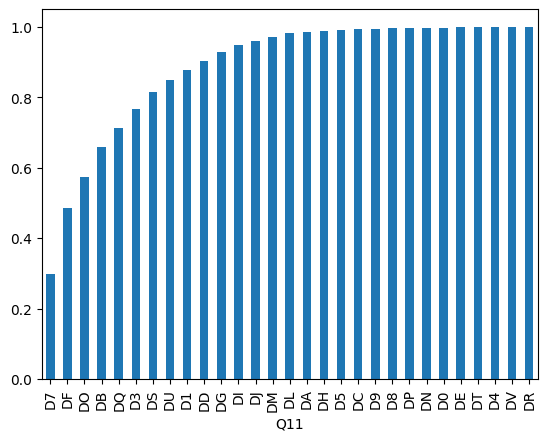

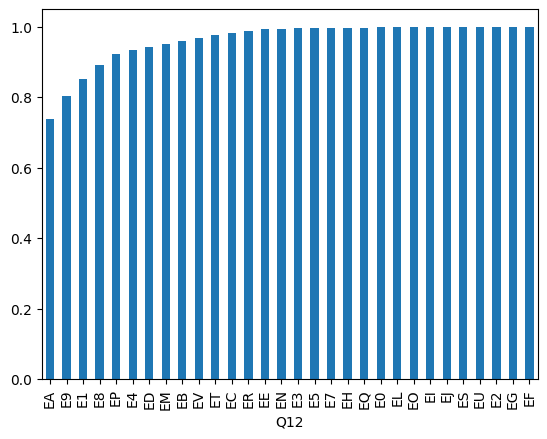

COD_INSEE
31555    751
6088     598
33063    559
44109    458
34172    385
        ... 
31320      1
83006      1
53202      1
65096      1
54128      1
Name: count, Length: 17347, dtype: int64

In [44]:
select_df[["COD_INSEE", "COD_IRIS"]] = select_df[["COD_INSEE", "COD_IRIS"]].astype("object")
recoded_df = select_df[torecode_columns.intersection(select_df.select_dtypes(["object", "string"]).columns)]
print(recoded_df.columns)
recoded_df["Q11"].value_counts(normalize=True).cumsum().plot(kind='bar')
plt.show()
recoded_df["Q12"].value_counts(normalize=True).cumsum().plot(kind='bar')
plt.show()
recoded_df["COD_INSEE"].value_counts()

In [45]:
def recode_feature(df, feature_name, threshold):
    # Calculate cumulative counts of unique values in the specified feature
    counts = (df[feature_name].value_counts() / len(df)).cumsum()

    # Create a dictionary mapping values to be replaced with "Other"
    values_to_replace = dict.fromkeys(counts[counts > threshold].index, "Other")

    # # Create a new column with recoded feature
    return df[feature_name].replace(values_to_replace)


select_df[f"Q11_new"] = recode_feature(select_df, "Q11", 0.8)
select_df[f"Q12_new"] = recode_feature(select_df, "Q12", 0.9)
select_df["Q11_new"].value_counts(), select_df["Q12_new"].value_counts()

(Q11_new
 D7       25297
 Other    19669
 DF       15940
 DO        7310
 DB        7202
 DQ        4694
 D3        4639
 Name: count, dtype: int64,
 Q12_new
 EA       62761
 Other     9135
 E9        5496
 E1        4208
 E8        3415
 Name: count, dtype: int64)

In [46]:
code_insee_df = (
    pd.read_csv("../data/external/code-insee.csv", sep=";")[["Code INSEE", "Code Département", "Code Région"]]
    .rename({"Code INSEE": "COD_INSEE", "Code Département": "CODE_DEPT", 
             "Code Région": "CODE_REGION"}, axis=1).astype("object")
)

In [47]:
# code_insee_df["COD_INSEE"].astype(int).sort_index()
select_df["COD_INSEE"] = select_df["COD_INSEE"].fillna("-99").astype(int)
code_insee_df["COD_INSEE"] = code_insee_df["COD_INSEE"].replace({r"^\d[A-Z]\d*$": "-5555"}, regex=True).astype(int)

# select_df
select_df.merge(code_insee_df, on="COD_INSEE", how="left")["CODE_REGION"].value_counts()

CODE_REGION
11    13185
82     8917
93     7264
52     6082
72     5637
53     5409
73     4792
31     4285
24     4263
91     4209
23     2635
54     2194
26     2146
41     2096
22     2083
25     2021
83     1706
21     1659
43     1409
74      906
42      854
Name: count, dtype: int64

In [50]:
select_df.to_parquet(f"{PROCESSED_DATA_PATH}/processed_training_full.parquet")

* COD_IRIS : use Target Encoder on COD_IRIS or use CODE_REGION, 
* Q11, Q12 with Target Encoder or One Hot with Q11_new, Q12_new 